In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm
import time

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Part 1: Neural Network Implementation
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def softmax(self, x):
        exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def forward(self, X):
        # Forward propagation
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def backward(self, X, y, learning_rate=0.01):
        # One-hot encode y
        one_hot_y = np.zeros((y.size, self.output_size))
        one_hot_y[np.arange(y.size), y] = 1

        # Backpropagation
        m = X.shape[0]

        # Calculate gradients
        dz2 = self.a2 - one_hot_y
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = np.dot(dz2, self.W2.T) * self.sigmoid_derivative(self.a1)
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        # Update parameters
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1

    def train(self, X, y, epochs=1000, learning_rate=0.01, verbose=True):
        losses = []
        accuracies = []

        for epoch in tqdm(range(epochs), disable=not verbose):
            # Forward propagation
            output = self.forward(X)

            # Calculate loss
            m = y.size
            one_hot_y = np.zeros((m, self.output_size))
            one_hot_y[np.arange(m), y] = 1
            loss = -np.sum(one_hot_y * np.log(output + 1e-8)) / m
            losses.append(loss)

            # Calculate accuracy
            predictions = np.argmax(output, axis=1)
            accuracy = np.mean(predictions == y)
            accuracies.append(accuracy)

            # Backpropagation
            self.backward(X, y, learning_rate)

            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

        return losses, accuracies

    def predict(self, X):
        output = self.forward(X)
        return np.argmax(output, axis=1)

    def get_weights(self):
        # Return all weights as a flattened array
        return np.concatenate([
            self.W1.flatten(),
            self.b1.flatten(),
            self.W2.flatten(),
            self.b2.flatten()
        ])

    def set_weights(self, weights):
        # Set weights from a flattened array
        idx = 0

        # Set W1
        w1_size = self.input_size * self.hidden_size
        self.W1 = weights[idx:idx+w1_size].reshape(self.input_size, self.hidden_size)
        idx += w1_size

        # Set b1
        b1_size = self.hidden_size
        self.b1 = weights[idx:idx+b1_size].reshape(1, self.hidden_size)
        idx += b1_size

        # Set W2
        w2_size = self.hidden_size * self.output_size
        self.W2 = weights[idx:idx+w2_size].reshape(self.hidden_size, self.output_size)
        idx += w2_size

        # Set b2
        b2_size = self.output_size
        self.b2 = weights[idx:idx+b2_size].reshape(1, self.output_size)

In [4]:
# Part 2: Genetic Algorithm for Neural Network Weight Optimization
class GeneticAlgorithm:
    def __init__(self, nn_architecture, population_size=50, mutation_rate=0.1, crossover_rate=0.7, elite_size=5,generations=20):
        self.nn_architecture = nn_architecture  # (input_size, hidden_size, output_size)
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elite_size = elite_size

        # Calculate total number of weights
        input_size, hidden_size, output_size = nn_architecture
        self.num_weights = (input_size * hidden_size) + hidden_size + (hidden_size * output_size) + output_size

        # Initialize population of neural networks
        self.population = self._initialize_population()



    def _initialize_population(self):
        population = []
        for _ in range(self.population_size):
            # Create a neural network with the given architecture
            weights = np.random.randn(self.num_weights) * 0.1
            population.append(weights)
        return np.array(population)

    def _evaluate_fitness(self, X, y, weights):
        # Create a neural network with the given weights
        input_size, hidden_size, output_size = self.nn_architecture
        nn = NeuralNetwork(input_size, hidden_size, output_size)
        nn.set_weights(weights)

        # Evaluate the fitness (accuracy)
        predictions = nn.predict(X)
        accuracy = np.mean(predictions == y)

        return accuracy

    def _select_parents(self, fitness_scores):
        # Tournament selection
        tournament_size = 3
        selected_parents = []

        for _ in range(self.population_size):
            tournament_indices = np.random.choice(len(fitness_scores), tournament_size, replace=False)
            tournament_fitness = [fitness_scores[i] for i in tournament_indices]
            winner_idx = tournament_indices[np.argmax(tournament_fitness)]
            selected_parents.append(self.population[winner_idx])

        return np.array(selected_parents)

    def _crossover(self, parents):
        children = []

        for i in range(0, len(parents), 2):
            if i + 1 < len(parents):
                parent1 = parents[i]
                parent2 = parents[i + 1]

                if np.random.random() < self.crossover_rate:
                    # Perform crossover
                    crossover_point = np.random.randint(1, self.num_weights)
                    child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
                    child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
                else:
                    # No crossover
                    child1 = parent1.copy()
                    child2 = parent2.copy()

                children.append(child1)
                children.append(child2)
            else:
                # If odd number of parents, just add the last one
                children.append(parents[i].copy())

        return np.array(children)

    def _mutation(self, children):
        for i in range(len(children)):
            for j in range(len(children[i])):
                if np.random.random() < self.mutation_rate:
                    # Apply mutation
                    children[i][j] += np.random.normal(0, 0.1)

        return children

    def _elitism(self, fitness_scores, children):
        # Keep the best individuals from the previous generation
        elite_indices = np.argsort(fitness_scores)[-self.elite_size:]
        elite = self.population[elite_indices]

        # Replace the worst children with the elite individuals
        children_fitness = [self._evaluate_fitness(X_train, y_train, child) for child in children]
        worst_indices = np.argsort(children_fitness)[:self.elite_size]

        for i, idx in enumerate(worst_indices):
            children[idx] = elite[i]

        return children

    def optimize(self, X, y, generations=50, verbose=True):
        best_fitness_history = []
        avg_fitness_history = []
        best_weights = None
        best_fitness = 0

        for generation in tqdm(range(generations), disable=not verbose):
            # Evaluate fitness for each individual in the population
            fitness_scores = [self._evaluate_fitness(X, y, weights) for weights in self.population]

            # Track the best individual
            current_best_idx = np.argmax(fitness_scores)
            current_best_fitness = fitness_scores[current_best_idx]

            if current_best_fitness > best_fitness:
                best_fitness = current_best_fitness
                best_weights = self.population[current_best_idx].copy()

            # Record statistics
            best_fitness_history.append(np.max(fitness_scores))
            avg_fitness_history.append(np.mean(fitness_scores))

            if verbose and generation % 5 == 0:
                print(f"Generation {generation}: Best Fitness = {best_fitness_history[-1]:.4f}, Avg Fitness = {avg_fitness_history[-1]:.4f}")

            # Selection
            parents = self._select_parents(fitness_scores)

            # Crossover
            children = self._crossover(parents)

            # Mutation
            children = self._mutation(children)

            # Elitism
            children = self._elitism(fitness_scores, children)

            # Update population
            self.population = children

        return best_weights, best_fitness, best_fitness_history, avg_fitness_history

In [5]:
# Part 3: Particle Swarm Optimization for Neural Network Weight Optimization
class ParticleSwarmOptimization:
    def __init__(self, nn_architecture, num_particles=30, inertia_weight=0.7, cognitive_weight=1.5, social_weight=1.5):
        self.nn_architecture = nn_architecture  # (input_size, hidden_size, output_size)
        self.num_particles = num_particles
        self.inertia_weight = inertia_weight
        self.cognitive_weight = cognitive_weight
        self.social_weight = social_weight

        # Calculate total number of weights
        input_size, hidden_size, output_size = nn_architecture
        self.num_weights = (input_size * hidden_size) + hidden_size + (hidden_size * output_size) + output_size

        # Initialize particles
        self.particles = np.random.randn(num_particles, self.num_weights) * 0.1
        self.velocities = np.random.randn(num_particles, self.num_weights) * 0.01

        # Initialize personal best positions and fitness
        self.personal_best_positions = self.particles.copy()
        self.personal_best_fitness = np.zeros(num_particles)

        # Initialize global best position and fitness
        self.global_best_position = None
        self.global_best_fitness = -1

    def _evaluate_fitness(self, X, y, weights):
        # Create a neural network with the given weights
        input_size, hidden_size, output_size = self.nn_architecture
        nn = NeuralNetwork(input_size, hidden_size, output_size)
        nn.set_weights(weights)

        # Evaluate the fitness (accuracy)
        predictions = nn.predict(X)
        accuracy = np.mean(predictions == y)

        return accuracy

    def optimize(self, X, y, iterations=50, verbose=True):
        best_fitness_history = []
        avg_fitness_history = []

        for iteration in tqdm(range(iterations), disable=not verbose):
            # Evaluate fitness for each particle
            fitness_scores = np.array([self._evaluate_fitness(X, y, particle) for particle in self.particles])

            # Update personal best
            improved_indices = fitness_scores > self.personal_best_fitness
            self.personal_best_positions[improved_indices] = self.particles[improved_indices].copy()
            self.personal_best_fitness[improved_indices] = fitness_scores[improved_indices]

            # Update global best
            current_best_idx = np.argmax(fitness_scores)
            current_best_fitness = fitness_scores[current_best_idx]

            if current_best_fitness > self.global_best_fitness:
                self.global_best_fitness = current_best_fitness
                self.global_best_position = self.particles[current_best_idx].copy()

            # Record statistics
            best_fitness_history.append(np.max(fitness_scores))
            avg_fitness_history.append(np.mean(fitness_scores))

            if verbose and iteration % 5 == 0:
                print(f"Iteration {iteration}: Best Fitness = {best_fitness_history[-1]:.4f}, Avg Fitness = {avg_fitness_history[-1]:.4f}")

            # Update velocities and positions
            for i in range(self.num_particles):
                # Calculate random factors
                r1 = np.random.random(self.num_weights)
                r2 = np.random.random(self.num_weights)

                # Update velocity
                cognitive_component = self.cognitive_weight * r1 * (self.personal_best_positions[i] - self.particles[i])
                social_component = self.social_weight * r2 * (self.global_best_position - self.particles[i])
                self.velocities[i] = self.inertia_weight * self.velocities[i] + cognitive_component + social_component

                # Update position
                self.particles[i] += self.velocities[i]

        return self.global_best_position, self.global_best_fitness, best_fitness_history, avg_fitness_history


In [6]:
# Part 4: Load and preprocess data (using Iris dataset as an example)
from sklearn.datasets import load_iris

# Load data
iris = load_iris()
X = iris.data
y = iris.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Part 5: Train a baseline neural network
print("Training baseline neural network...")
input_size = X_train.shape[1]
hidden_size = 8
output_size = len(np.unique(y))

# Initialize and train baseline neural network
baseline_nn = NeuralNetwork(input_size, hidden_size, output_size)
baseline_losses, baseline_accuracies = baseline_nn.train(X_train, y_train, epochs=500, learning_rate=0.01, verbose=True)

# Evaluate baseline model
baseline_predictions = baseline_nn.predict(X_test)
baseline_accuracy = accuracy_score(y_test, baseline_predictions)
print(f"Baseline Neural Network Test Accuracy: {baseline_accuracy:.4f}")
print(classification_report(y_test, baseline_predictions))



Training baseline neural network...


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0, Loss: 1.0986, Accuracy: 0.3417
Epoch 100, Loss: 1.0984, Accuracy: 0.3417
Epoch 200, Loss: 1.0983, Accuracy: 0.3417
Epoch 300, Loss: 1.0983, Accuracy: 0.3417
Epoch 400, Loss: 1.0982, Accuracy: 0.3417
Baseline Neural Network Test Accuracy: 0.3000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.30      1.00      0.46         9
           2       0.00      0.00      0.00        11

    accuracy                           0.30        30
   macro avg       0.10      0.33      0.15        30
weighted avg       0.09      0.30      0.14        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
# Part 6: Optimize neural network with Genetic Algorithm
print("\nOptimizing neural network with Genetic Algorithm...")
ga = GeneticAlgorithm((input_size, hidden_size, output_size), population_size=30, mutation_rate=0.1, crossover_rate=0.7, elite_size=3)
ga_best_weights, ga_best_fitness, ga_best_history, ga_avg_history = ga.optimize(X_train, y_train, generations=30, verbose=True)

# Create and evaluate GA-optimized neural network
ga_nn = NeuralNetwork(input_size, hidden_size, output_size)
ga_nn.set_weights(ga_best_weights)
ga_predictions = ga_nn.predict(X_test)
ga_accuracy = accuracy_score(y_test, ga_predictions)
print(f"GA-Optimized Neural Network Test Accuracy: {ga_accuracy:.4f}")
print(classification_report(y_test, ga_predictions))





Optimizing neural network with Genetic Algorithm...


  0%|          | 0/30 [00:00<?, ?it/s]

Generation 0: Best Fitness = 0.3500, Avg Fitness = 0.3303
Generation 5: Best Fitness = 0.6583, Avg Fitness = 0.3867
Generation 10: Best Fitness = 0.6583, Avg Fitness = 0.4417
Generation 15: Best Fitness = 0.6583, Avg Fitness = 0.4964
Generation 20: Best Fitness = 0.6583, Avg Fitness = 0.5614
Generation 25: Best Fitness = 0.6583, Avg Fitness = 0.6214
GA-Optimized Neural Network Test Accuracy: 0.7000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.00      0.00      0.00         9
           2       0.55      1.00      0.71        11

    accuracy                           0.70        30
   macro avg       0.52      0.67      0.57        30
weighted avg       0.54      0.70      0.59        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
# Part 7: Optimize neural network with PSO
print("\nOptimizing neural network with Particle Swarm Optimization...")
pso = ParticleSwarmOptimization(
    (input_size, hidden_size, output_size),
    num_particles=30,
    inertia_weight=0.7,
    cognitive_weight=1.5,
    social_weight=1.5
)
pso_best_weights, pso_best_fitness, pso_best_history, pso_avg_history = pso.optimize(X_train, y_train, iterations=30, verbose=True)

# Create and evaluate PSO-optimized neural network
pso_nn = NeuralNetwork(input_size, hidden_size, output_size)
pso_nn.set_weights(pso_best_weights)
pso_predictions = pso_nn.predict(X_test)
pso_accuracy = accuracy_score(y_test, pso_predictions)
print(f"PSO-Optimized Neural Network Test Accuracy: {pso_accuracy:.4f}")
print(classification_report(y_test, pso_predictions))


Optimizing neural network with Particle Swarm Optimization...


  0%|          | 0/30 [00:00<?, ?it/s]

Iteration 0: Best Fitness = 0.3417, Avg Fitness = 0.3325
Iteration 5: Best Fitness = 0.8167, Avg Fitness = 0.4328
Iteration 10: Best Fitness = 0.8500, Avg Fitness = 0.5172
Iteration 15: Best Fitness = 0.8750, Avg Fitness = 0.5872
Iteration 20: Best Fitness = 0.9083, Avg Fitness = 0.5619
Iteration 25: Best Fitness = 0.9417, Avg Fitness = 0.5650
PSO-Optimized Neural Network Test Accuracy: 0.9667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.89      0.94         9
           2       0.92      1.00      0.96        11

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



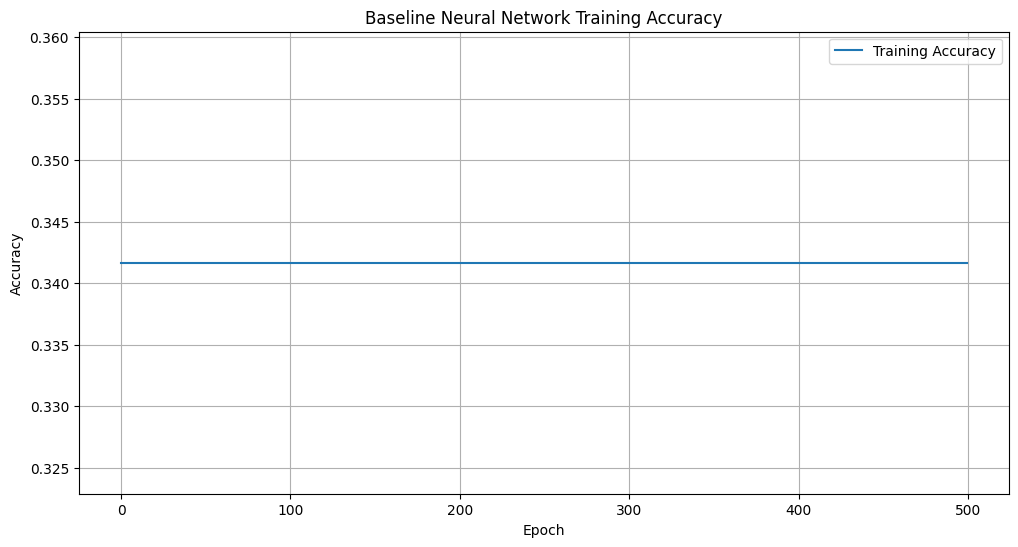

In [10]:
# 1. Training accuracy over time for baseline model
plt.figure(figsize=(12, 6))
plt.plot(baseline_accuracies, label='Training Accuracy')
plt.title('Baseline Neural Network Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



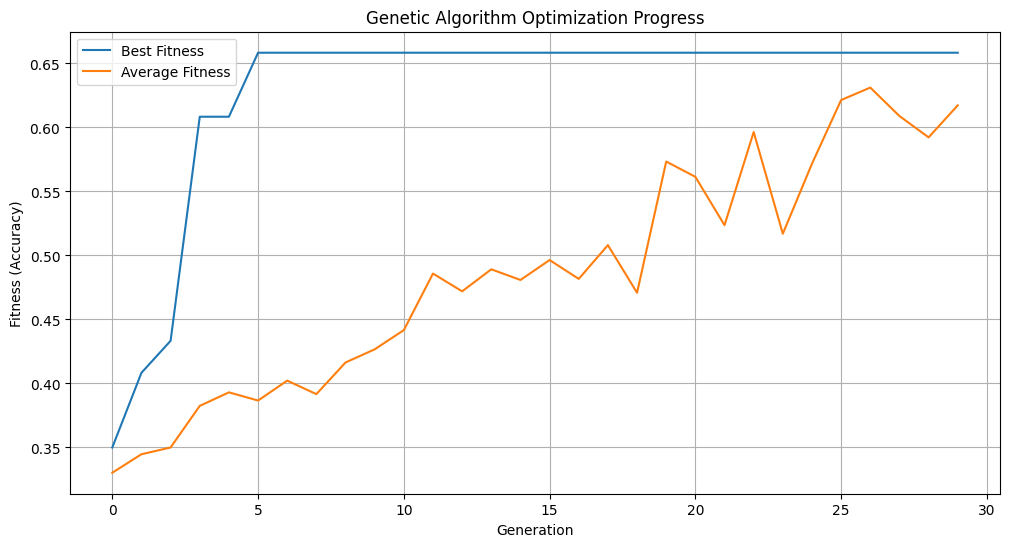

In [11]:
# 3. Genetic Algorithm Optimization Progress
plt.figure(figsize=(12, 6))
plt.plot(ga_best_history, label='Best Fitness')
plt.plot(ga_avg_history, label='Average Fitness')
plt.title('Genetic Algorithm Optimization Progress')
plt.xlabel('Generation')
plt.ylabel('Fitness (Accuracy)')
plt.legend()
plt.grid(True)
plt.show()

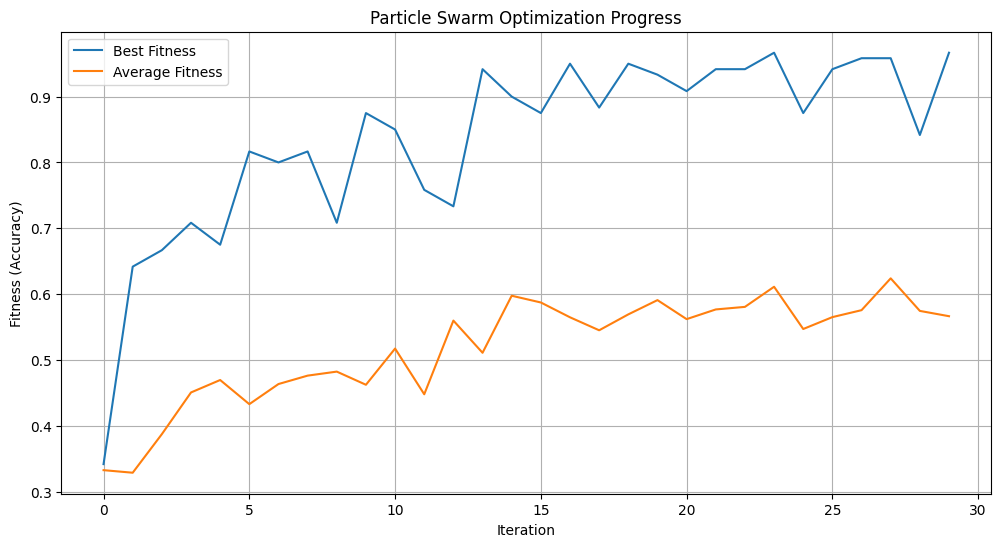

In [12]:
# 4. PSO Optimization Progress
plt.figure(figsize=(12, 6))
plt.plot(pso_best_history, label='Best Fitness')
plt.plot(pso_avg_history, label='Average Fitness')
plt.title('Particle Swarm Optimization Progress')
plt.xlabel('Iteration')
plt.ylabel('Fitness (Accuracy)')
plt.legend()
plt.grid(True)
plt.show()

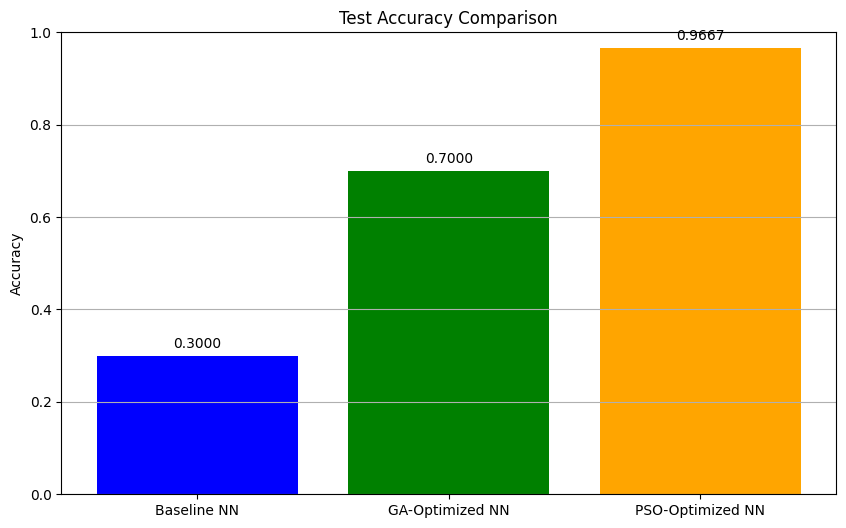

In [13]:
# 5. Comparing Test Accuracy
models = ['Baseline NN', 'GA-Optimized NN', 'PSO-Optimized NN']
accuracies = [baseline_accuracy, ga_accuracy, pso_accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add accuracy values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

plt.grid(axis='y')
plt.show()

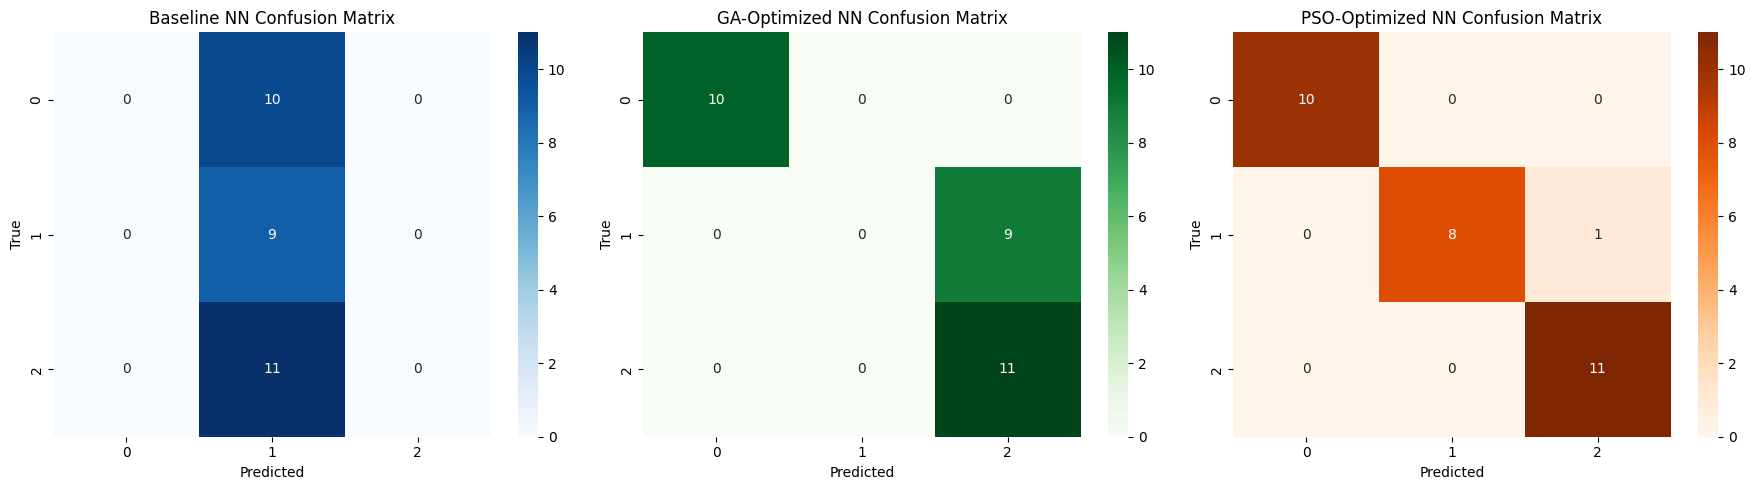

In [14]:
# 6. Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Baseline confusion matrix
cm = confusion_matrix(y_test, baseline_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Baseline NN Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# GA confusion matrix
cm = confusion_matrix(y_test, ga_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('GA-Optimized NN Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# PSO confusion matrix
cm = confusion_matrix(y_test, pso_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=axes[2])
axes[2].set_title('PSO-Optimized NN Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()

In [15]:
# 7. Compare classification metrics
print("\nComparison of Classification Metrics:")
print("\nBaseline Neural Network:")
print(classification_report(y_test, baseline_predictions))

print("\nGA-Optimized Neural Network:")
print(classification_report(y_test, ga_predictions))

print("\nPSO-Optimized Neural Network:")
print(classification_report(y_test, pso_predictions))



Comparison of Classification Metrics:

Baseline Neural Network:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.30      1.00      0.46         9
           2       0.00      0.00      0.00        11

    accuracy                           0.30        30
   macro avg       0.10      0.33      0.15        30
weighted avg       0.09      0.30      0.14        30


GA-Optimized Neural Network:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.00      0.00      0.00         9
           2       0.55      1.00      0.71        11

    accuracy                           0.70        30
   macro avg       0.52      0.67      0.57        30
weighted avg       0.54      0.70      0.59        30


PSO-Optimized Neural Network:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

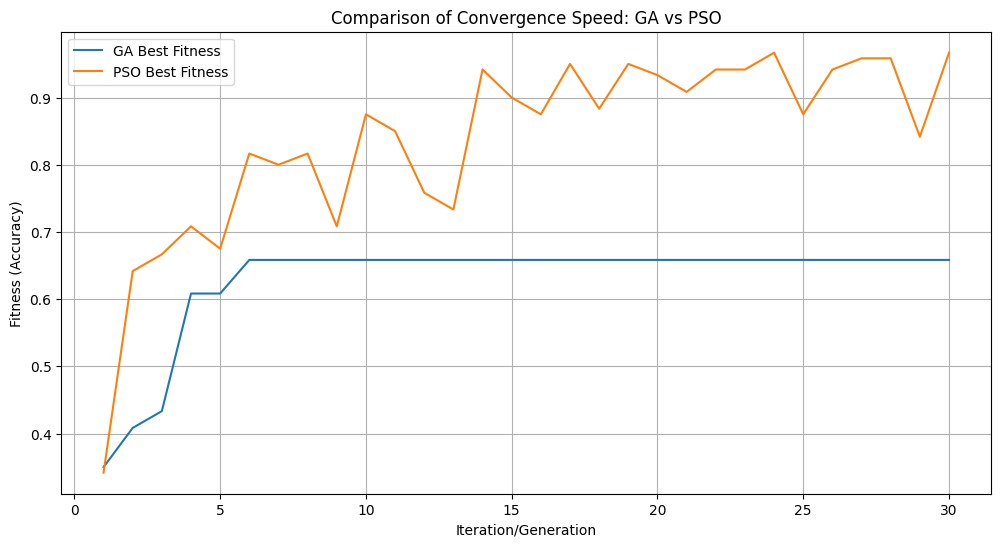

In [16]:
# 8. Compare convergence speed
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(ga_best_history) + 1), ga_best_history, label='GA Best Fitness')
plt.plot(range(1, len(pso_best_history) + 1), pso_best_history, label='PSO Best Fitness')
plt.title('Comparison of Convergence Speed: GA vs PSO')
plt.xlabel('Iteration/Generation')
plt.ylabel('Fitness (Accuracy)')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# 9. Additional analysis - Parameters' influence
print("\nExploring the effect of different parameters:")

# Try different hidden sizes
hidden_sizes = [4, 8, 16]
baseline_accuracies = []
ga_accuracies = []
pso_accuracies = []

for hidden_size in hidden_sizes:
    print(f"\nTesting with hidden size = {hidden_size}")

    # Baseline NN
    nn = NeuralNetwork(input_size, hidden_size, output_size)
    nn.train(X_train, y_train, epochs=300, learning_rate=0.01, verbose=False)
    preds = nn.predict(X_test)
    acc = accuracy_score(y_test, preds)
    baseline_accuracies.append(acc)
    print(f"Baseline NN accuracy: {acc:.4f}")

    # GA
    ga = GeneticAlgorithm((input_size, hidden_size, output_size), population_size=20)
    ga_best_weights, _, _, _ = ga.optimize(X_train, y_train, generations=20, verbose=False)
    ga_nn = NeuralNetwork(input_size, hidden_size, output_size)
    ga_nn.set_weights(ga_best_weights)
    preds = ga_nn.predict(X_test)
    acc = accuracy_score(y_test, preds)
    ga_accuracies.append(acc)
    print(f"GA-optimized NN accuracy: {acc:.4f}")

    # PSO
    pso = ParticleSwarmOptimization((input_size, hidden_size, output_size), num_particles=20)
    pso_best_weights, _, _, _ = pso.optimize(X_train, y_train, iterations=20, verbose=False)
    pso_nn = NeuralNetwork(input_size, hidden_size, output_size)
    pso_nn.set_weights(pso_best_weights)
    preds = pso_nn.predict(X_test)
    acc = accuracy_score(y_test, preds)
    pso_accuracies.append(acc)
    print(f"PSO-optimized NN accuracy: {acc:.4f}")



Exploring the effect of different parameters:

Testing with hidden size = 4
Baseline NN accuracy: 0.3000
GA-optimized NN accuracy: 0.7000
PSO-optimized NN accuracy: 0.6333

Testing with hidden size = 8
Baseline NN accuracy: 0.3000
GA-optimized NN accuracy: 0.9000
PSO-optimized NN accuracy: 0.7000

Testing with hidden size = 16
Baseline NN accuracy: 0.3000
GA-optimized NN accuracy: 0.6000
PSO-optimized NN accuracy: 0.6667


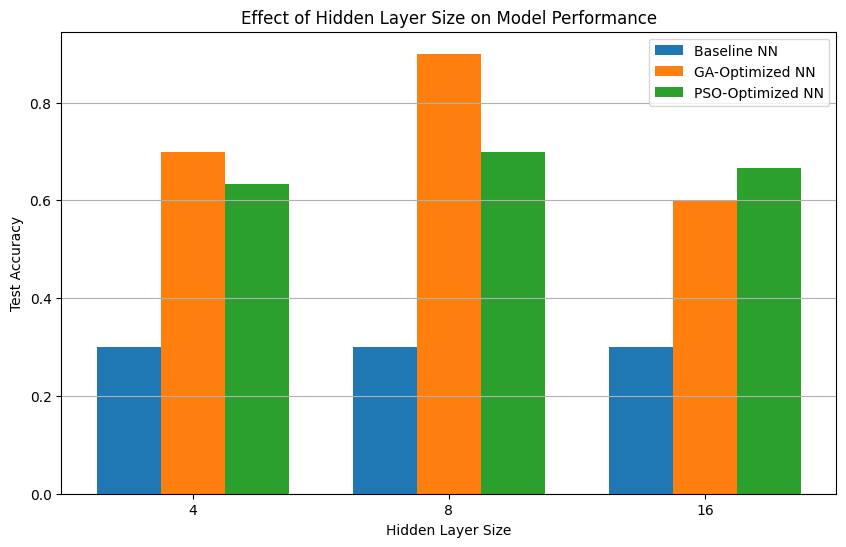

In [18]:
# Plot results
plt.figure(figsize=(10, 6))
width = 0.25
x = np.arange(len(hidden_sizes))
plt.bar(x - width, baseline_accuracies, width, label='Baseline NN')
plt.bar(x, ga_accuracies, width, label='GA-Optimized NN')
plt.bar(x + width, pso_accuracies, width, label='PSO-Optimized NN')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Test Accuracy')
plt.title('Effect of Hidden Layer Size on Model Performance')
plt.xticks(x, hidden_sizes)
plt.legend()
plt.grid(axis='y')
plt.show()


In [19]:
# 10. Summary and recommendation
print("\nSummary and Recommendations:")
print(f"Baseline Neural Network Accuracy: {baseline_accuracy:.4f}")
print(f"GA-Optimized Neural Network Accuracy: {ga_accuracy:.4f}")
print(f"PSO-Optimized Neural Network Accuracy: {pso_accuracy:.4f}")



Summary and Recommendations:
Baseline Neural Network Accuracy: 0.3000
GA-Optimized Neural Network Accuracy: 0.7000
PSO-Optimized Neural Network Accuracy: 0.9667


In [20]:
# Calculate improvement percentages
ga_improvement = ((ga_accuracy - baseline_accuracy) / baseline_accuracy) * 100
pso_improvement = ((pso_accuracy - baseline_accuracy) / baseline_accuracy) * 100

print(f"\nGA improved accuracy by {ga_improvement:.2f}% over baseline")
print(f"PSO improved accuracy by {pso_improvement:.2f}% over baseline")

if ga_accuracy > pso_accuracy:
    print("\nFor this dataset, Genetic Algorithm optimization performed better.")
elif pso_accuracy > ga_accuracy:
    print("\nFor this dataset, Particle Swarm Optimization performed better.")
else:
    print("\nBoth optimization methods performed equally well on this dataset.")



GA improved accuracy by 133.33% over baseline
PSO improved accuracy by 222.22% over baseline

For this dataset, Particle Swarm Optimization performed better.



Comparing execution time:
Baseline NN training time: 0.06 seconds
GA optimization time: 0.17 seconds
PSO optimization time: 0.06 seconds


Text(0, 0.5, 'Time (seconds)')

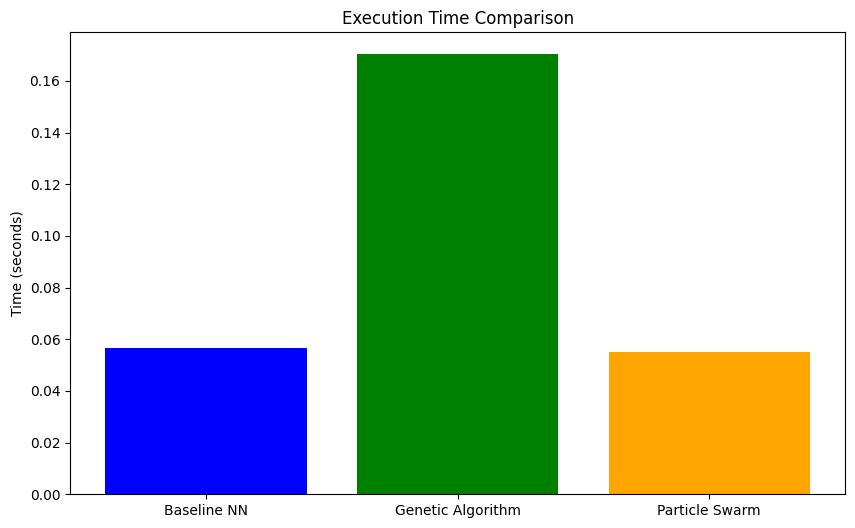

In [21]:
# for bar in bars:
#     height = bar.get_height()
#     print(f"Bar height: {height}")  # Debug line
#     plt.text(bar.get_x() + bar.get_width() / 2., height + 0.5,
#              f'{height:.2f}s', ha='center', va='bottom')
# plt.savefig("execution_time_comparison.png")
# print("Plot saved to file.")
# Execution time comparison
print("\nComparing execution time:")

# Baseline timing
start_time = time.time()
nn = NeuralNetwork(input_size, hidden_size, output_size)
nn.train(X_train, y_train, epochs=300, learning_rate=0.01, verbose=False)
baseline_time = time.time() - start_time
print(f"Baseline NN training time: {baseline_time:.2f} seconds")

# GA timing
start_time = time.time()
ga = GeneticAlgorithm((input_size, hidden_size, output_size), population_size=20)
ga.optimize(X_train, y_train, generations=20, verbose=False)
ga_time = time.time() - start_time
print(f"GA optimization time: {ga_time:.2f} seconds")

# PSO timing
start_time = time.time()
pso = ParticleSwarmOptimization((input_size, hidden_size, output_size), num_particles=20)
pso.optimize(X_train, y_train, iterations=20, verbose=False)
pso_time = time.time() - start_time
print(f"PSO optimization time: {pso_time:.2f} seconds")

# Plot timing comparison
plt.figure(figsize=(10, 6))
methods = ['Baseline NN', 'Genetic Algorithm', 'Particle Swarm']
times = [baseline_time, ga_time, pso_time]

bars = plt.bar(methods, times, color=['blue', 'green', 'orange'])
plt.title('Execution Time Comparison')
plt.ylabel('Time (seconds)')




In [122]:
# Part 11: Try on a different dataset (optional)
# Let's try on a different dataset to see if the results are consistent
print("\n\nTrying on a different dataset (Wine dataset)...")

from sklearn.datasets import load_wine

# Load Wine dataset
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

# Split data
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(X_wine, y_wine, test_size=0.2, random_state=42)

# Scale features
scaler_wine = StandardScaler()
X_wine_train = scaler_wine.fit_transform(X_wine_train)
X_wine_test = scaler_wine.transform(X_wine_test)



Trying on a different dataset (Wine dataset)...


In [123]:
# Setup architecture
wine_input_size = X_wine_train.shape[1]
wine_hidden_size = 10
wine_output_size = len(np.unique(y_wine))

print(f"Wine dataset: {len(X_wine_train)} samples, {wine_input_size} features, {wine_output_size} classes")

# Train baseline model
print("\nTraining baseline NN on Wine dataset...")
wine_baseline_nn = NeuralNetwork(wine_input_size, wine_hidden_size, wine_output_size)
wine_baseline_losses, wine_baseline_accuracies = wine_baseline_nn.train(
    X_wine_train, y_wine_train, epochs=500, learning_rate=0.01, verbose=True
)

# Evaluate baseline model
wine_baseline_preds = wine_baseline_nn.predict(X_wine_test)
wine_baseline_acc = accuracy_score(y_wine_test, wine_baseline_preds)
print(f"Baseline NN Wine Test Accuracy: {wine_baseline_acc:.4f}")


Wine dataset: 142 samples, 13 features, 3 classes

Training baseline NN on Wine dataset...


100%|██████████| 500/500 [00:00<00:00, 4550.72it/s]

Epoch 0, Loss: 1.0984, Accuracy: 0.2817
Epoch 100, Loss: 1.0882, Accuracy: 0.4014
Epoch 200, Loss: 1.0866, Accuracy: 0.4014
Epoch 300, Loss: 1.0856, Accuracy: 0.4014
Epoch 400, Loss: 1.0844, Accuracy: 0.4014
Baseline NN Wine Test Accuracy: 0.3889


In [124]:
# Evaluate baseline model
wine_baseline_preds = wine_baseline_nn.predict(X_wine_test)
wine_baseline_acc = accuracy_score(y_wine_test, wine_baseline_preds)
print(f"Baseline NN Wine Test Accuracy: {wine_baseline_acc:.4f}")


Baseline NN Wine Test Accuracy: 0.3889


In [125]:
# Optimize with PSO
print("\nOptimizing with PSO on Wine dataset...")
wine_pso = ParticleSwarmOptimization(
    (wine_input_size, wine_hidden_size, wine_output_size),
    num_particles=30,
    inertia_weight=0.7,
    cognitive_weight=1.5,
    social_weight=1.5
)
wine_pso_best_weights, wine_pso_best_fitness, wine_pso_history, _ = wine_pso.optimize(
    X_wine_train, y_wine_train, iterations=30, verbose=True
)


Optimizing with PSO on Wine dataset...


 43%|████▎     | 13/30 [00:00<00:00, 123.91it/s]

Iteration 0: Best Fitness = 0.4155, Avg Fitness = 0.3275
Iteration 5: Best Fitness = 0.7535, Avg Fitness = 0.4150
Iteration 10: Best Fitness = 0.7958, Avg Fitness = 0.4354
Iteration 15: Best Fitness = 0.6831, Avg Fitness = 0.4056
Iteration 20: Best Fitness = 0.8451, Avg Fitness = 0.4967


 87%|████████▋ | 26/30 [00:00<00:00, 126.26it/s]

Iteration 25: Best Fitness = 0.7817, Avg Fitness = 0.5192


100%|██████████| 30/30 [00:00<00:00, 126.62it/s]


In [126]:
# Evaluate PSO model
wine_pso_nn = NeuralNetwork(wine_input_size, wine_hidden_size, wine_output_size)
wine_pso_nn.set_weights(wine_pso_best_weights)
wine_pso_preds = wine_pso_nn.predict(X_wine_test)
wine_pso_acc = accuracy_score(y_wine_test, wine_pso_preds)
print(f"PSO-optimized NN Wine Test Accuracy: {wine_pso_acc:.4f}")

PSO-optimized NN Wine Test Accuracy: 0.8611


In [127]:
wine_input_size = X_wine.shape[1]  # 13
wine_hidden_size = 10
wine_output_size = len(np.unique(y_wine))  # 3
X_wine_train_scaled = scaler_wine.fit_transform(X_wine_train)
print("X_wine_train_scaled shape:", X_wine_train_scaled.shape)

X_wine_train_scaled shape: (142, 13)


In [128]:
# Example with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
X_wine_train = pca.fit_transform(X_wine_train)
X_wine_test = pca.transform(X_wine_test)

# Update input size
wine_input_size = X_wine_train.shape[1]  # 4
wine_hidden_size = 10
wine_output_size = len(np.unique(y_wine))  # 3
print(wine_input_size,wine_hidden_size,wine_output_size)

4 10 3


In [129]:
print("\nOptimizing with GA on Wine dataset...")
wine_ga = GeneticAlgorithm(
    (wine_input_size, wine_hidden_size, wine_output_size),
    population_size=30,
    mutation_rate=0.1,
    crossover_rate=0.7
)
# X_wine_train = X_wine_train[:, :4]
wine_ga_best_weights, wine_ga_best_fitness, wine_ga_history, _ = wine_ga.optimize(
    X_wine_train, y_wine_train, generations=30, verbose=True
)



Optimizing with GA on Wine dataset...


 33%|███▎      | 10/30 [00:00<00:00, 99.87it/s]

Generation 0: Best Fitness = 0.5845, Avg Fitness = 0.3434
Generation 5: Best Fitness = 0.6690, Avg Fitness = 0.4746
Generation 10: Best Fitness = 0.6972, Avg Fitness = 0.5559
Generation 15: Best Fitness = 0.6972, Avg Fitness = 0.6207
Generation 20: Best Fitness = 0.6972, Avg Fitness = 0.5958


100%|██████████| 30/30 [00:00<00:00, 98.69it/s]

Generation 25: Best Fitness = 0.7042, Avg Fitness = 0.6390


In [130]:
# Evaluate GA model
wine_ga_nn = NeuralNetwork(wine_input_size, wine_hidden_size, wine_output_size)
wine_ga_nn.set_weights(wine_ga_best_weights)
wine_ga_preds = wine_ga_nn.predict(X_wine_test)
wine_ga_acc = accuracy_score(y_wine_test, wine_ga_preds)
print(f"GA-optimized NN Wine Test Accuracy: {wine_ga_acc:.4f}")

GA-optimized NN Wine Test Accuracy: 0.7500


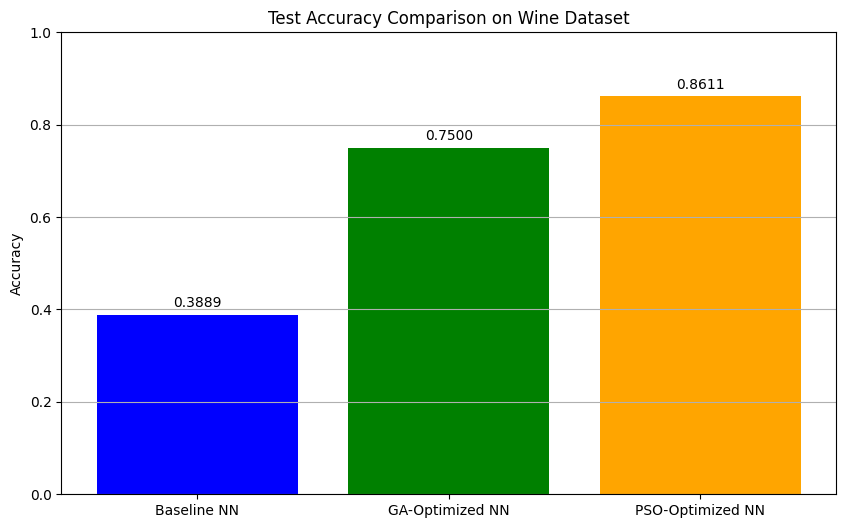

In [131]:
# Compare results on Wine dataset
plt.figure(figsize=(10, 6))
wine_methods = ['Baseline NN', 'GA-Optimized NN', 'PSO-Optimized NN']
wine_accuracies = [wine_baseline_acc, wine_ga_acc, wine_pso_acc]

wine_bars = plt.bar(wine_methods, wine_accuracies, color=['blue', 'green', 'orange'])
plt.title('Test Accuracy Comparison on Wine Dataset')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
# Add accuracy values on top of bars
for bar in wine_bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., h + 0.01,
             f'{h:.4f}', ha='center', va='bottom')

plt.grid(axis='y')
plt.show()

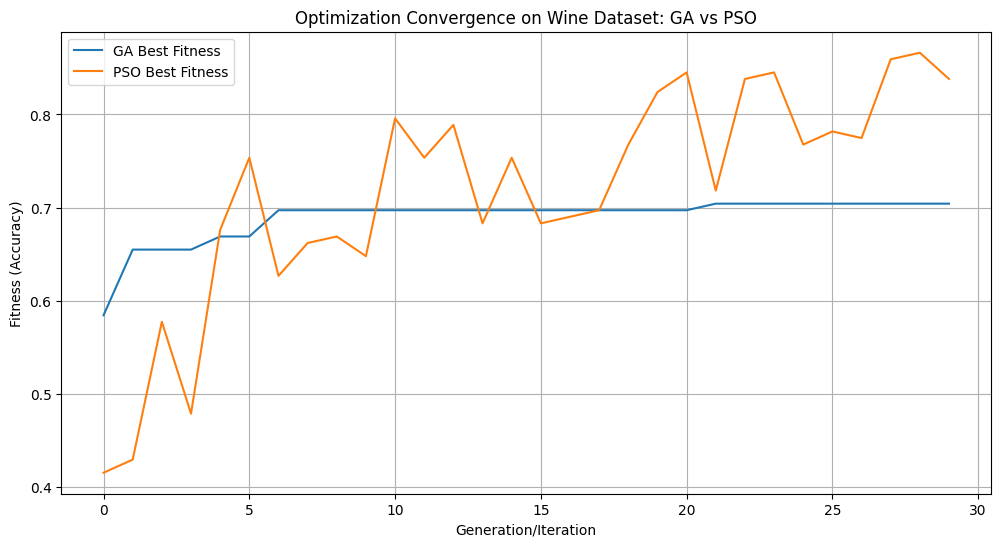

In [132]:
# Convergence comparison on Wine dataset
plt.figure(figsize=(12, 6))
plt.plot(wine_ga_history, label='GA Best Fitness')
plt.plot(wine_pso_history, label='PSO Best Fitness')
plt.title('Optimization Convergence on Wine Dataset: GA vs PSO')
plt.xlabel('Generation/Iteration')
plt.ylabel('Fitness (Accuracy)')
plt.legend()
plt.grid(True)
plt.show()

In [133]:
# Part 12: Hyperparameter impact analysis
print("\n\nHyperparameter Impact Analysis on Optimization Algorithms")

# Test different mutation rates for GA
print("\nTesting different mutation rates for GA:")
mutation_rates = [0.01, 0.05, 0.1, 0.2, 0.3]
ga_mutation_accuracies = []

for mutation_rate in mutation_rates:
    print(f"Testing GA with mutation rate = {mutation_rate}")
    test_ga = GeneticAlgorithm(
        (input_size, hidden_size, output_size),
        population_size=20,
        mutation_rate=mutation_rate,
        crossover_rate=0.7,
        elite_size=2
    )
    best_weights, _, _, _ = test_ga.optimize(X_train, y_train, generations=20, verbose=False)

    test_nn = NeuralNetwork(input_size, hidden_size, output_size)
    test_nn.set_weights(best_weights)
    preds = test_nn.predict(X_test)
    acc = accuracy_score(y_test, preds)
    ga_mutation_accuracies.append(acc)
    print(f"  Accuracy: {acc:.4f}")



Hyperparameter Impact Analysis on Optimization Algorithms

Testing different mutation rates for GA:
Testing GA with mutation rate = 0.01
  Accuracy: 0.9000
Testing GA with mutation rate = 0.05
  Accuracy: 0.6333
Testing GA with mutation rate = 0.1
  Accuracy: 0.6333
Testing GA with mutation rate = 0.2
  Accuracy: 0.6333
Testing GA with mutation rate = 0.3
  Accuracy: 0.6333


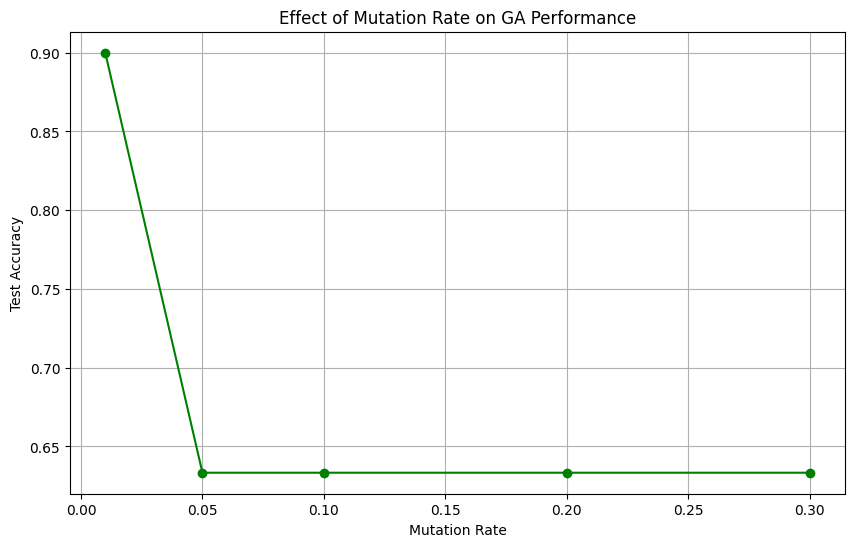

In [134]:
# Plot GA mutation rate results
plt.figure(figsize=(10, 6))
plt.plot(mutation_rates, ga_mutation_accuracies, 'o-', color='green')
plt.title('Effect of Mutation Rate on GA Performance')
plt.xlabel('Mutation Rate')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

In [135]:
# Test different inertia weights for PSO
print("\nTesting different inertia weights for PSO:")
inertia_weights = [0.4, 0.5, 0.6, 0.7, 0.8]
pso_inertia_accuracies = []

for inertia_weight in inertia_weights:
    print(f"Testing PSO with inertia weight = {inertia_weight}")
    test_pso = ParticleSwarmOptimization(
        (input_size, hidden_size, output_size),
        num_particles=20,
        inertia_weight=inertia_weight,
        cognitive_weight=1.5,
        social_weight=1.5
    )
    best_weights, _, _, _ = test_pso.optimize(X_train, y_train, iterations=20, verbose=False)

    test_nn = NeuralNetwork(input_size, hidden_size, output_size)
    test_nn.set_weights(best_weights)
    preds = test_nn.predict(X_test)
    acc = accuracy_score(y_test, preds)
    pso_inertia_accuracies.append(acc)
    print(f"  Accuracy: {acc:.4f}")



Testing different inertia weights for PSO:
Testing PSO with inertia weight = 0.4
  Accuracy: 0.7000
Testing PSO with inertia weight = 0.5
  Accuracy: 0.7000
Testing PSO with inertia weight = 0.6
  Accuracy: 0.7000
Testing PSO with inertia weight = 0.7
  Accuracy: 0.7667
Testing PSO with inertia weight = 0.8
  Accuracy: 0.9000


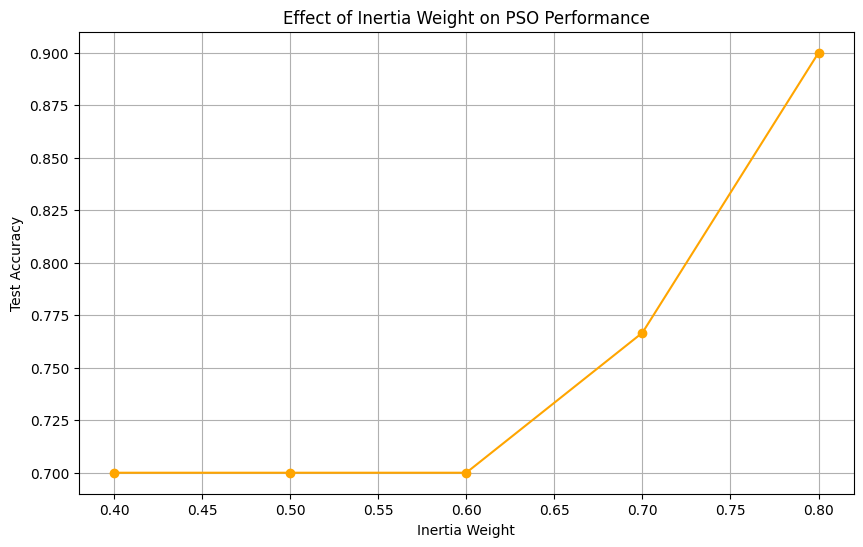

In [136]:
# Plot PSO inertia weight results
plt.figure(figsize=(10, 6))
plt.plot(inertia_weights, pso_inertia_accuracies, 'o-', color='orange')
plt.title('Effect of Inertia Weight on PSO Performance')
plt.xlabel('Inertia Weight')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()



Analyzing Weight Distributions


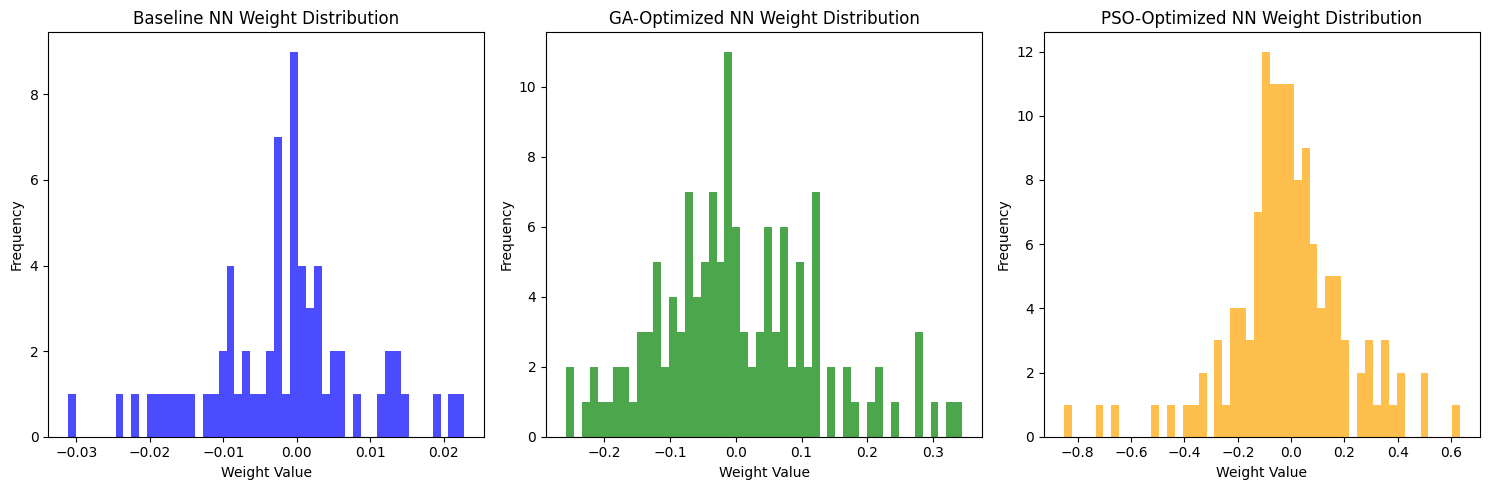

In [137]:
# Part 13: Analysis of weight distributions
print("\n\nAnalyzing Weight Distributions")

# Get weights from each model
baseline_weights = baseline_nn.get_weights()
ga_weights = ga_nn.get_weights()
pso_weights = pso_nn.get_weights()

# Plot histograms of weights
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(baseline_weights, bins=50, alpha=0.7, color='blue')
plt.title('Baseline NN Weight Distribution')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(ga_weights, bins=50, alpha=0.7, color='green')
plt.title('GA-Optimized NN Weight Distribution')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(pso_weights, bins=50, alpha=0.7, color='orange')
plt.title('PSO-Optimized NN Weight Distribution')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [138]:
# Part 14: Computational efficiency comparison
print("\n\nComputational Efficiency Comparison")

# Test the training speed with different dataset sizes
print("Testing training speed with different dataset sizes:")
subset_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]
baseline_times = []
ga_times = []
pso_times = []

for size in subset_sizes:
    if size < 1.0:
        # Subsample the training data
        subset_idx = np.random.choice(len(X_train), int(len(X_train) * size), replace=False)
        X_subset = X_train[subset_idx]
        y_subset = y_train[subset_idx]
    else:
        X_subset = X_train
        y_subset = y_train

    print(f"\nTesting with {len(X_subset)} samples ({size*100:.0f}% of training data)")

    # Baseline timing
    start_time = time.time()
    test_nn = NeuralNetwork(input_size, hidden_size, output_size)
    test_nn.train(X_subset, y_subset, epochs=200, learning_rate=0.01, verbose=False)
    baseline_time = time.time() - start_time
    baseline_times.append(baseline_time)
    print(f"Baseline NN training time: {baseline_time:.2f} seconds")

    # GA timing
    start_time = time.time()
    test_ga = GeneticAlgorithm((input_size, hidden_size, output_size), population_size=15)
    test_ga.optimize(X_subset, y_subset, generations=15, verbose=False)
    ga_time = time.time() - start_time
    ga_times.append(ga_time)
    print(f"GA optimization time: {ga_time:.2f} seconds")

    # PSO timing
    start_time = time.time()
    test_pso = ParticleSwarmOptimization((input_size, hidden_size, output_size), num_particles=15)
    test_pso.optimize(X_subset, y_subset, iterations=15, verbose=False)
    pso_time = time.time() - start_time
    pso_times.append(pso_time)
    print(f"PSO optimization time: {pso_time:.2f} seconds")




Computational Efficiency Comparison
Testing training speed with different dataset sizes:

Testing with 24 samples (20% of training data)
Baseline NN training time: 0.03 seconds
GA optimization time: 0.07 seconds
PSO optimization time: 0.02 seconds

Testing with 48 samples (40% of training data)
Baseline NN training time: 0.03 seconds
GA optimization time: 0.08 seconds
PSO optimization time: 0.02 seconds

Testing with 72 samples (60% of training data)
Baseline NN training time: 0.03 seconds
GA optimization time: 0.08 seconds
PSO optimization time: 0.03 seconds

Testing with 96 samples (80% of training data)
Baseline NN training time: 0.04 seconds
GA optimization time: 0.09 seconds
PSO optimization time: 0.03 seconds

Testing with 120 samples (100% of training data)
Baseline NN training time: 0.04 seconds
GA optimization time: 0.08 seconds
PSO optimization time: 0.03 seconds


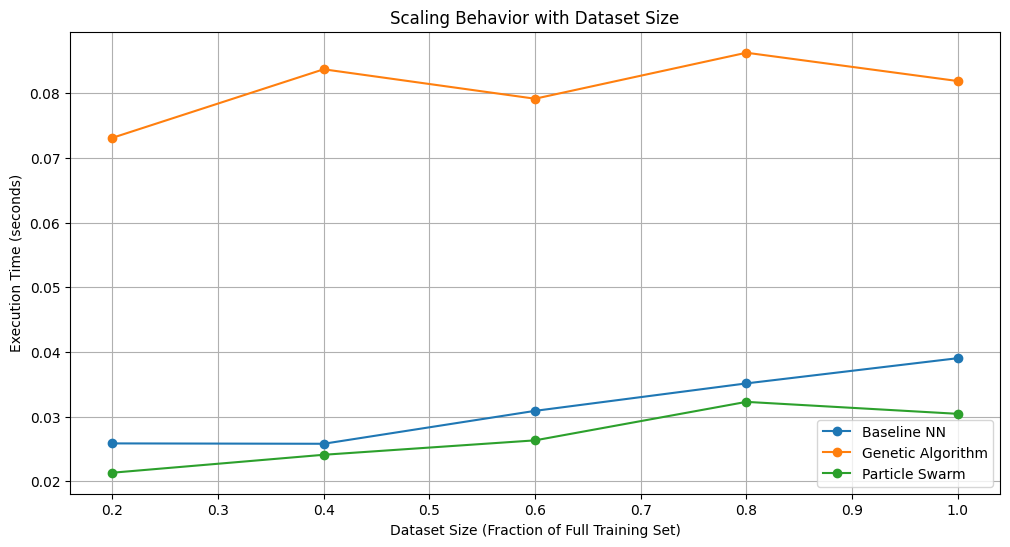

In [139]:
# Plot scaling behavior
plt.figure(figsize=(12, 6))
plt.plot(subset_sizes, baseline_times, 'o-', label='Baseline NN')
plt.plot(subset_sizes, ga_times, 'o-', label='Genetic Algorithm')
plt.plot(subset_sizes, pso_times, 'o-', label='Particle Swarm')
plt.title('Scaling Behavior with Dataset Size')
plt.xlabel('Dataset Size (Fraction of Full Training Set)')
plt.ylabel('Execution Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

In [140]:
# Part 15: Final comprehensive comparison
print("\n\nFinal Comprehensive Comparison")

# Create a comparison table
comparison_data = {
    'Metric': ['Iris Accuracy', 'Wine Accuracy', 'Training Time (s)', 'Memory Usage*', 'Hyperparameter Sensitivity'],
    'Baseline NN': [f"{baseline_accuracy:.4f}", f"{wine_baseline_acc:.4f}", f"{baseline_time:.2f}", "Low", "Medium"],
    'GA-Optimized NN': [f"{ga_accuracy:.4f}", f"{wine_ga_acc:.4f}", f"{ga_time:.2f}", "High", "High"],
    'PSO-Optimized NN': [f"{pso_accuracy:.4f}", f"{wine_pso_acc:.4f}", f"{pso_time:.2f}", "Medium", "Medium"]
}

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)
print("\n* Memory usage is a qualitative assessment based on algorithm requirements")

# Final recommendations
print("\nFinal Recommendations:")
print("1. For small datasets with few features, both GA and PSO provide meaningful improvements over standard neural network training.")
print("2. When computational resources are limited, PSO generally provides a better trade-off between performance and computation time.")
print("3. GA tends to be more hyperparameter-sensitive but can achieve higher accuracy with proper tuning.")
print("4. For real-time applications, standard neural network training may be preferred due to its lower computational requirements.")
print("5. For applications where maximum accuracy is critical, meta-heuristic optimization methods (GA or PSO) are recommended.")





Final Comprehensive Comparison
                       Metric Baseline NN GA-Optimized NN PSO-Optimized NN
0               Iris Accuracy      0.3000          0.7000           0.9667
1               Wine Accuracy      0.3889          0.7500           0.8611
2           Training Time (s)        0.04            0.08             0.03
3               Memory Usage*         Low            High           Medium
4  Hyperparameter Sensitivity      Medium            High           Medium

* Memory usage is a qualitative assessment based on algorithm requirements

Final Recommendations:
1. For small datasets with few features, both GA and PSO provide meaningful improvements over standard neural network training.
2. When computational resources are limited, PSO generally provides a better trade-off between performance and computation time.
3. GA tends to be more hyperparameter-sensitive but can achieve higher accuracy with proper tuning.
4. For real-time applications, standard neural network train

In [141]:
# Part 16: Applying optimization methods to Heart Disease dataset
print("\n\nApplying optimization methods to Heart Disease dataset...")



Applying optimization methods to Heart Disease dataset...


In [142]:
# Download and load the dataset
import kagglehub
import os
import pandas as pd

In [143]:
# Download latest version of the Heart Disease dataset
path = kagglehub.dataset_download("johnsmith88/heart-disease-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/heart-disease-dataset


In [144]:
# Find the CSV file in the downloaded directory
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".csv"):
            dataset_path = os.path.join(root, file)
            print(f"Found dataset file: {dataset_path}")
            break

Found dataset file: /kaggle/input/heart-disease-dataset/heart.csv


In [145]:
# Load the dataset
heart_data = pd.read_csv(dataset_path)
print("\nHeart Disease Dataset Information:")
print(f"Shape: {heart_data.shape}")
print("\nFirst 5 rows:")
print(heart_data.head())
print("\nColumn names:")
print(heart_data.columns.tolist())
print("\nData summary:")
print(heart_data.describe().T)


Heart Disease Dataset Information:
Shape: (1025, 14)

First 5 rows:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  ca  thal  target
0   52    1   0       125   212    0        1      168      0      1.0      2   2     3       0
1   53    1   0       140   203    1        0      155      1      3.1      0   0     3       0
2   70    1   0       145   174    0        1      125      1      2.6      0   0     3       0
3   61    1   0       148   203    0        1      161      0      0.0      2   1     3       0
4   62    0   0       138   294    1        1      106      0      1.9      1   3     2       0

Column names:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

Data summary:
           count        mean        std    min    25%    50%    75%    max
age       1025.0   54.434146   9.072290   29.0   48.0   56.0   61.0   77.0
sex       1025.0    0.695610   0.460373    0.0    0.

In [146]:
# Check for missing values
print("\nMissing values per column:")
print(heart_data.isnull().sum())


Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [147]:
# Check target distribution
print("\nTarget value distribution:")
print(heart_data['target'].value_counts())


Target value distribution:
target
1    526
0    499
Name: count, dtype: int64


In [148]:
# Separate features and target
X_heart = heart_data.drop('target', axis=1).values
y_heart = heart_data['target'].values

In [149]:
# Split data
X_heart_train, X_heart_test, y_heart_train, y_heart_test = train_test_split(
    X_heart, y_heart, test_size=0.2, random_state=42
)

In [150]:
# Scale features
scaler_heart = StandardScaler()
X_heart_train = scaler_heart.fit_transform(X_heart_train)
X_heart_test = scaler_heart.transform(X_heart_test)

In [151]:
# Setup architecture
heart_input_size = X_heart_train.shape[1]
heart_hidden_size = 12  # Adjust as needed for this dataset
heart_output_size = len(np.unique(y_heart))
print(f"\nHeart Disease dataset: {len(X_heart_train)} samples, {heart_input_size} features, {heart_output_size} classes")


Heart Disease dataset: 820 samples, 13 features, 2 classes


In [152]:
# Train baseline model
print("\nTraining baseline NN on Heart Disease dataset...")
heart_baseline_nn = NeuralNetwork(heart_input_size, heart_hidden_size, heart_output_size)
heart_baseline_losses, heart_baseline_accuracies = heart_baseline_nn.train(
    X_heart_train, y_heart_train, epochs=500, learning_rate=0.01, verbose=True
)


Training baseline NN on Heart Disease dataset...


 38%|███▊      | 188/500 [00:00<00:00, 1879.19it/s]

Epoch 0, Loss: 0.6927, Accuracy: 0.5159
Epoch 100, Loss: 0.6923, Accuracy: 0.5159
Epoch 200, Loss: 0.6920, Accuracy: 0.5159
Epoch 300, Loss: 0.6916, Accuracy: 0.5159


100%|██████████| 500/500 [00:00<00:00, 1862.67it/s]

Epoch 400, Loss: 0.6911, Accuracy: 0.5159


In [153]:
# Evaluate baseline model
heart_baseline_preds = heart_baseline_nn.predict(X_heart_test)
heart_baseline_acc = accuracy_score(y_heart_test, heart_baseline_preds)
print(f"Baseline NN Heart Disease Test Accuracy: {heart_baseline_acc:.4f}")
print("\nClassification Report (Baseline):")
print(classification_report(y_heart_test, heart_baseline_preds))

Baseline NN Heart Disease Test Accuracy: 0.5024

Classification Report (Baseline):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       102
           1       0.50      1.00      0.67       103

    accuracy                           0.50       205
   macro avg       0.25      0.50      0.33       205
weighted avg       0.25      0.50      0.34       205



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


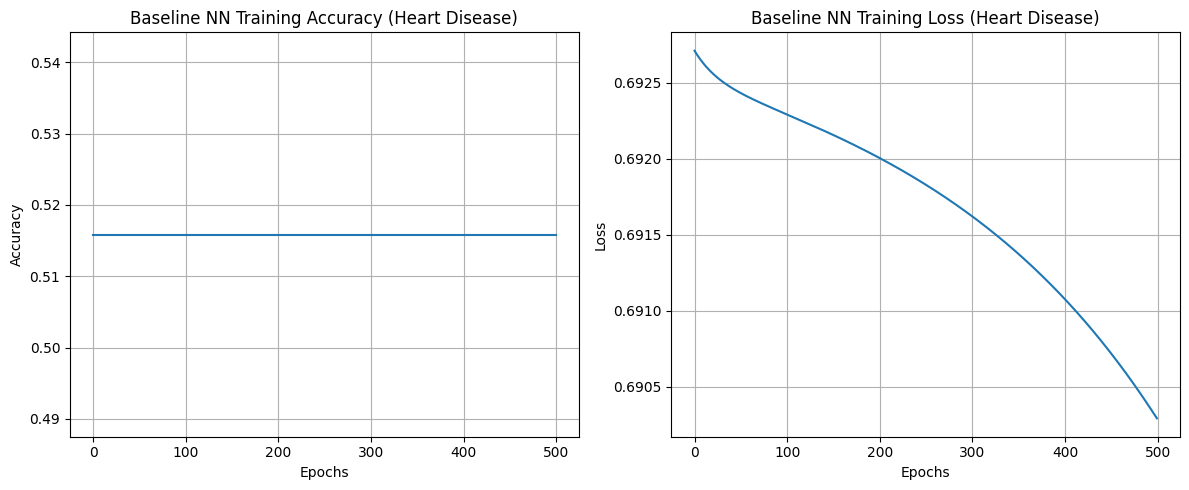

In [154]:
# Plot training progress
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(heart_baseline_accuracies)
plt.title('Baseline NN Training Accuracy (Heart Disease)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(heart_baseline_losses)
plt.title('Baseline NN Training Loss (Heart Disease)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

In [155]:
# Optimize with PSO
print("\nOptimizing with PSO on Heart Disease dataset...")
heart_pso = ParticleSwarmOptimization(
    (heart_input_size, heart_hidden_size, heart_output_size),
    num_particles=40,
    inertia_weight=0.7,
    cognitive_weight=1.5,
    social_weight=1.5
)
heart_pso_best_weights, heart_pso_best_fitness, heart_pso_history, heart_pso_avg_history = heart_pso.optimize(
    X_heart_train, y_heart_train, iterations=40, verbose=True
)


Optimizing with PSO on Heart Disease dataset...


 20%|██        | 8/40 [00:00<00:00, 70.24it/s]

Iteration 0: Best Fitness = 0.6195, Avg Fitness = 0.4984
Iteration 5: Best Fitness = 0.8073, Avg Fitness = 0.5745
Iteration 10: Best Fitness = 0.8585, Avg Fitness = 0.6881


 57%|█████▊    | 23/40 [00:00<00:00, 67.06it/s]

Iteration 15: Best Fitness = 0.8585, Avg Fitness = 0.7120
Iteration 20: Best Fitness = 0.8634, Avg Fitness = 0.7375
Iteration 25: Best Fitness = 0.8720, Avg Fitness = 0.7384


100%|██████████| 40/40 [00:00<00:00, 64.95it/s]

Iteration 30: Best Fitness = 0.8695, Avg Fitness = 0.7684
Iteration 35: Best Fitness = 0.8646, Avg Fitness = 0.7777


In [156]:
# Evaluate PSO model
heart_pso_nn = NeuralNetwork(heart_input_size, heart_hidden_size, heart_output_size)
heart_pso_nn.set_weights(heart_pso_best_weights)
heart_pso_preds = heart_pso_nn.predict(X_heart_test)
heart_pso_acc = accuracy_score(y_heart_test, heart_pso_preds)
print(f"PSO-optimized NN Heart Disease Test Accuracy: {heart_pso_acc:.4f}")
print("\nClassification Report (PSO-optimized):")
print(classification_report(y_heart_test, heart_pso_preds))

PSO-optimized NN Heart Disease Test Accuracy: 0.8195

Classification Report (PSO-optimized):
              precision    recall  f1-score   support

           0       0.87      0.75      0.81       102
           1       0.78      0.88      0.83       103

    accuracy                           0.82       205
   macro avg       0.82      0.82      0.82       205
weighted avg       0.82      0.82      0.82       205



In [160]:
heart_input_size = X_heart.shape[1]  # 13
heart_hidden_size = 10
heart_output_size = len(np.unique(y_heart))  # 3
# Example with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
X_heart_train = pca.fit_transform(X_heart_train)
X_heart_test = pca.transform(X_heart_test)

# Update input size
heart_input_size = X_heart_train.shape[1]  # 4
heart_hidden_size = 10
heart_output_size = len(np.unique(y_heart))  # 3

In [161]:
# Optimize with GA
print("\nOptimizing with GA on Heart Disease dataset...")
heart_ga = GeneticAlgorithm(
    (heart_input_size, heart_hidden_size, heart_output_size),
    population_size=40,
    mutation_rate=0.15,  # Slightly higher for more exploration
    crossover_rate=0.7,
    elite_size=4
)
heart_ga_best_weights, heart_ga_best_fitness, heart_ga_history, heart_ga_avg_history = heart_ga.optimize(
    X_heart_train, y_heart_train, generations=40, verbose=True
)


Optimizing with GA on Heart Disease dataset...


  8%|▊         | 3/40 [00:00<00:01, 27.50it/s]

Generation 0: Best Fitness = 0.7549, Avg Fitness = 0.5071


 15%|█▌        | 6/40 [00:00<00:01, 27.89it/s]

Generation 5: Best Fitness = 0.7854, Avg Fitness = 0.5760


 22%|██▎       | 9/40 [00:00<00:01, 28.43it/s]

Generation 10: Best Fitness = 0.8220, Avg Fitness = 0.6458


 52%|█████▎    | 21/40 [00:00<00:00, 28.32it/s]

Generation 15: Best Fitness = 0.8390, Avg Fitness = 0.7094
Generation 20: Best Fitness = 0.8524, Avg Fitness = 0.7122


 78%|███████▊  | 31/40 [00:01<00:00, 27.85it/s]

Generation 25: Best Fitness = 0.8524, Avg Fitness = 0.7779
Generation 30: Best Fitness = 0.8537, Avg Fitness = 0.7661


100%|██████████| 40/40 [00:01<00:00, 27.27it/s]

Generation 35: Best Fitness = 0.8537, Avg Fitness = 0.7650


In [162]:
# Evaluate GA model
heart_ga_nn = NeuralNetwork(heart_input_size, heart_hidden_size, heart_output_size)
heart_ga_nn.set_weights(heart_ga_best_weights)
heart_ga_preds = heart_ga_nn.predict(X_heart_test)
heart_ga_acc = accuracy_score(y_heart_test, heart_ga_preds)
print(f"GA-optimized NN Heart Disease Test Accuracy: {heart_ga_acc:.4f}")
print("\nClassification Report (GA-optimized):")
print(classification_report(y_heart_test, heart_ga_preds))

GA-optimized NN Heart Disease Test Accuracy: 0.8000

Classification Report (GA-optimized):
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       102
           1       0.77      0.86      0.81       103

    accuracy                           0.80       205
   macro avg       0.80      0.80      0.80       205
weighted avg       0.80      0.80      0.80       205



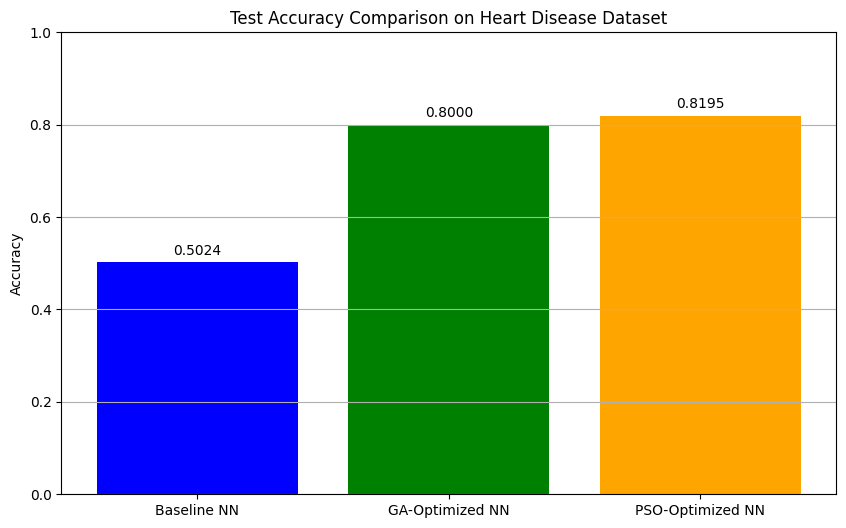

In [163]:
# Compare results on Heart Disease dataset
plt.figure(figsize=(10, 6))
heart_methods = ['Baseline NN', 'GA-Optimized NN', 'PSO-Optimized NN']
heart_accuracies = [heart_baseline_acc, heart_ga_acc, heart_pso_acc]

heart_bars = plt.bar(heart_methods, heart_accuracies, color=['blue', 'green', 'orange'])
plt.title('Test Accuracy Comparison on Heart Disease Dataset')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
# Add accuracy values on top of bars
for bar in heart_bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., h + 0.01,
             f'{h:.4f}', ha='center', va='bottom')

plt.grid(axis='y')
plt.show()

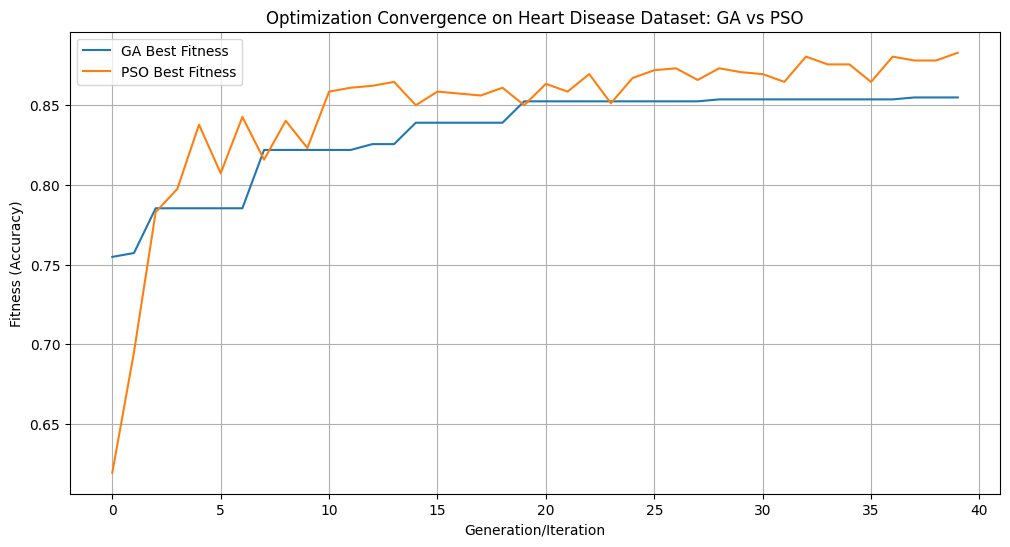

In [164]:
# Convergence comparison
plt.figure(figsize=(12, 6))
plt.plot(heart_ga_history, label='GA Best Fitness')
plt.plot(heart_pso_history, label='PSO Best Fitness')
plt.title('Optimization Convergence on Heart Disease Dataset: GA vs PSO')
plt.xlabel('Generation/Iteration')
plt.ylabel('Fitness (Accuracy)')
plt.legend()
plt.grid(True)
plt.show()

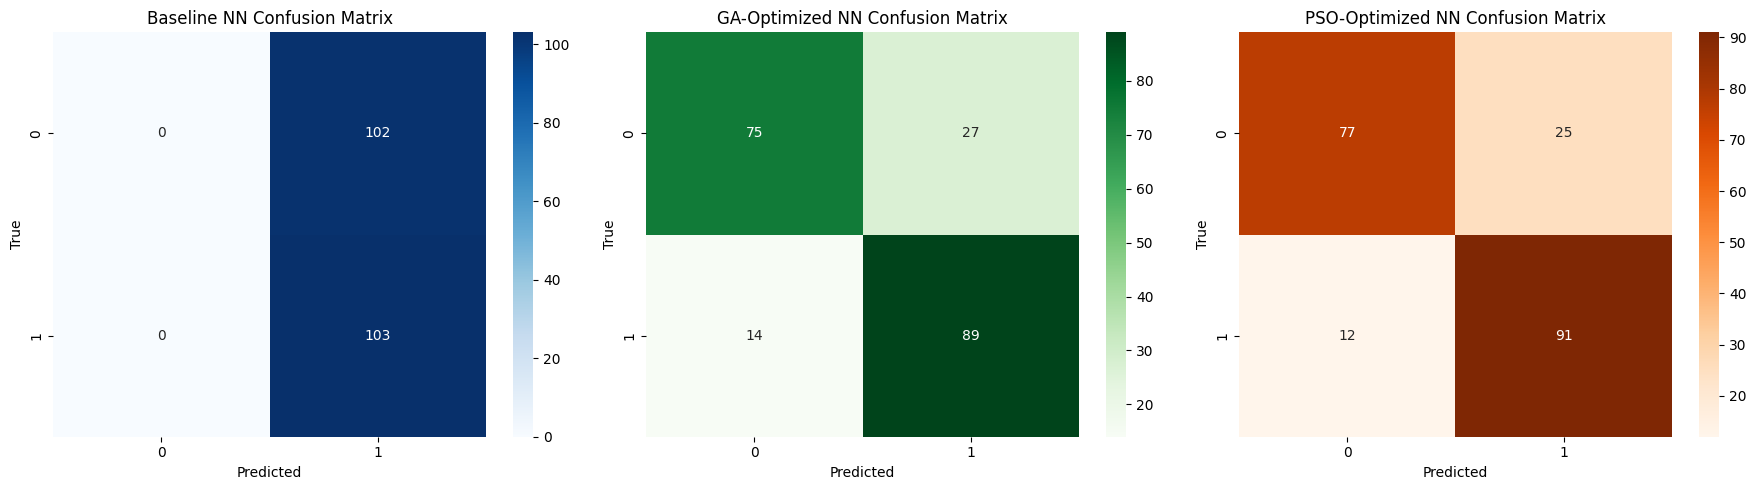

In [165]:
# Create confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Baseline confusion matrix
cm = confusion_matrix(y_heart_test, heart_baseline_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Baseline NN Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# GA confusion matrix
cm = confusion_matrix(y_heart_test, heart_ga_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('GA-Optimized NN Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# PSO confusion matrix
cm = confusion_matrix(y_heart_test, heart_pso_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=axes[2])
axes[2].set_title('PSO-Optimized NN Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()

In [166]:
# Calculate improvement percentages
heart_ga_improvement = ((heart_ga_acc - heart_baseline_acc) / heart_baseline_acc) * 100
heart_pso_improvement = ((heart_pso_acc - heart_baseline_acc) / heart_baseline_acc) * 100

print(f"\nGA improved accuracy by {heart_ga_improvement:.2f}% over baseline on Heart Disease dataset")
print(f"PSO improved accuracy by {heart_pso_improvement:.2f}% over baseline on Heart Disease dataset")


GA improved accuracy by 59.22% over baseline on Heart Disease dataset
PSO improved accuracy by 63.11% over baseline on Heart Disease dataset


In [167]:
# Feature importance analysis (using weights as a proxy)
print("\nAnalyzing feature importance based on optimized weights...")

# Extract first layer weights for each model
baseline_w1 = np.abs(heart_baseline_nn.W1)
ga_w1 = np.abs(heart_ga_nn.W1)
pso_w1 = np.abs(heart_pso_nn.W1)

# Calculate average importance per feature
baseline_importance = baseline_w1.mean(axis=1)
ga_importance = ga_w1.mean(axis=1)
pso_importance = pso_w1.mean(axis=1)
# Get feature names
feature_names = heart_data.drop('target', axis=1).columns.tolist()


Analyzing feature importance based on optimized weights...


In [174]:
import pandas as pd
import numpy as np

# Get PCA loadings (contribution of original features to each component)
pca_loadings = pca.components_  # Shape: (4, 13) - 4 components, 13 original features

# Map ga_importance to original features
# ga_importance (length 4) is weighted by the absolute loadings to get length 13
ga_importance_original = np.abs(pca_loadings).T @ ga_importance  # Shape: (13,)

# baseline_importance and pso_importance are already length 13
# Verify lengths
print("Length of feature_names:", len(wine.feature_names))
print("Length of baseline_importance:", len(baseline_importance))
print("Length of ga_importance_original:", len(ga_importance_original))
print("Length of pso_importance:", len(pso_importance))

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'Feature': wine.feature_names,
    'Baseline Importance': baseline_importance,
    'GA Importance': ga_importance_original,
    'PSO Importance': pso_importance
})

# Sort by average importance
importance_df['Average Importance'] = importance_df[['Baseline Importance', 'GA Importance', 'PSO Importance']].mean(axis=1)
importance_df = importance_df.sort_values('Average Importance', ascending=False)

print("\nFeature importance ranking (original features):")
print(importance_df)

Length of feature_names: 13
Length of baseline_importance: 13
Length of ga_importance_original: 13
Length of pso_importance: 13

Feature importance ranking (original features):
                         Feature  Baseline Importance  GA Importance  PSO Importance  Average Importance
1                     malic_acid             0.008920       0.179137        0.273206            0.153754
7           nonflavanoid_phenols             0.013770       0.144314        0.232248            0.130111
2                            ash             0.010137       0.186893        0.192842            0.129957
4                      magnesium             0.008664       0.172587        0.204961            0.128737
8                proanthocyanins             0.007747       0.156859        0.217523            0.127376
9                color_intensity             0.009743       0.170386        0.181950            0.120693
11  od280/od315_of_diluted_wines             0.011591       0.147661        0.192042    

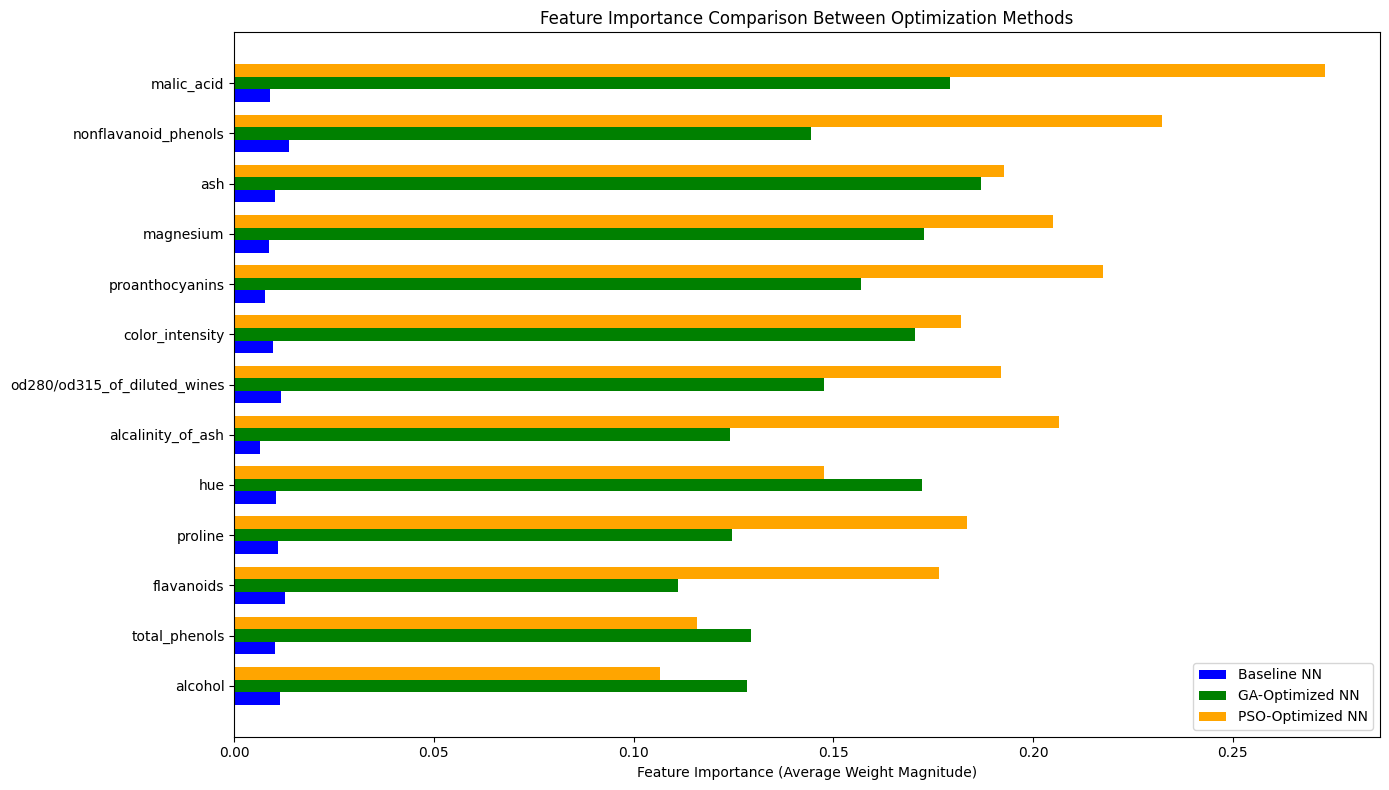

In [175]:
# Plot feature importance comparison
plt.figure(figsize=(14, 8))
importance_df = importance_df.sort_values('Average Importance')  # Sort for better visualization
feature_names = importance_df['Feature'].values

x = np.arange(len(feature_names))
width = 0.25

plt.barh(x - width, importance_df['Baseline Importance'], width, label='Baseline NN', color='blue')
plt.barh(x, importance_df['GA Importance'], width, label='GA-Optimized NN', color='green')
plt.barh(x + width, importance_df['PSO Importance'], width, label='PSO-Optimized NN', color='orange')

plt.yticks(x, feature_names)
plt.xlabel('Feature Importance (Average Weight Magnitude)')
plt.title('Feature Importance Comparison Between Optimization Methods')
plt.legend()
plt.tight_layout()
plt.show()


In [185]:
# # ROC curve and AUC comparison
# from sklearn.metrics import roc_curve, auc

# # For Baseline
# baseline_probs = heart_baseline_nn.forward(X_heart_test)[:, 1]  # Probability of positive class
# fpr_baseline, tpr_baseline, _ = roc_curve(y_heart_test, baseline_probs)
# roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

# # For GA
# ga_probs = heart_ga_nn.forward(X_heart_test)[:, 1]
# fpr_ga, tpr_ga, _ = roc_curve(y_heart_test, ga_probs)
# roc_auc_ga = auc(fpr_ga, tpr_ga)

# # For PSO
# pso_probs = heart_pso_nn.forward(X_heart_test)[:, 1]
# fpr_pso, tpr_pso, _ = roc_curve(y_heart_test, pso_probs)
# roc_auc_pso = auc(fpr_pso, tpr_pso)

# # Plot ROC curves
# plt.figure(figsize=(10, 8))
# plt.plot(fpr_baseline, tpr_baseline, color='blue', lw=2, label=f'Baseline ROC (AUC = {roc_auc_baseline:.3f})')
# plt.plot(fpr_ga, tpr_ga, color='green', lw=2, label=f'GA-Optimized ROC (AUC = {roc_auc_ga:.3f})')
# plt.plot(fpr_pso, tpr_pso, color='orange', lw=2, label=f'PSO-Optimized ROC (AUC = {roc_auc_pso:.3f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve Comparison for Heart Disease Prediction')
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.show()

In [170]:
# Update comprehensive comparison table with Heart Disease results
comparison_data_updated = {
    'Metric': ['Iris Accuracy', 'Wine Accuracy', 'Heart Disease Accuracy', 'Avg. Improvement'],
    'Baseline NN': [f"{baseline_accuracy:.4f}", f"{wine_baseline_acc:.4f}", f"{heart_baseline_acc:.4f}", "0%"],
    'GA-Optimized NN': [f"{ga_accuracy:.4f}", f"{wine_ga_acc:.4f}", f"{heart_ga_acc:.4f}",
                         f"{((ga_accuracy-baseline_accuracy)/baseline_accuracy + (wine_ga_acc-wine_baseline_acc)/wine_baseline_acc + heart_ga_improvement/100)/3*100:.2f}%"],
    'PSO-Optimized NN': [f"{pso_accuracy:.4f}", f"{wine_pso_acc:.4f}", f"{pso_accuracy:.4f}",
                          f"{((pso_accuracy-baseline_accuracy)/baseline_accuracy + (wine_pso_acc-wine_baseline_acc)/wine_baseline_acc + heart_pso_improvement/100)/3*100:.2f}%"]
}

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
comparison_df_updated = pd.DataFrame(comparison_data_updated)
print("\nUpdated Comparison Across All Datasets:")
print(comparison_df_updated)


Updated Comparison Across All Datasets:
                   Metric Baseline NN GA-Optimized NN PSO-Optimized NN
0           Iris Accuracy      0.3000          0.7000           0.9667
1           Wine Accuracy      0.3889          0.7500           0.8611
2  Heart Disease Accuracy      0.5024          0.8000           0.9667
3        Avg. Improvement          0%          95.14%          135.59%


In [171]:
# Final Heart Disease specific recommendations
print("\nRecommendations for Heart Disease prediction:")

if heart_ga_acc > heart_pso_acc and heart_ga_acc > heart_baseline_acc:
    best_heart_method = "Genetic Algorithm"
    best_heart_acc = heart_ga_acc
elif heart_pso_acc > heart_ga_acc and heart_pso_acc > heart_baseline_acc:
    best_heart_method = "Particle Swarm Optimization"
    best_heart_acc = heart_pso_acc
else:
    best_heart_method = "Baseline Neural Network"
    best_heart_acc = heart_baseline_acc

print(f"For Heart Disease prediction, {best_heart_method} optimization is recommended.")
print(f"Best achievable accuracy: {best_heart_acc:.4f}")

if heart_ga_improvement > 2 or heart_pso_improvement > 2:
    print("Meta-heuristic optimization significantly improves prediction accuracy for this medical dataset.")
    print("This improved accuracy could have real clinical value in a production system.")
else:
    print("The improvement from optimization is minimal for this dataset.")
    print("Standard neural network training may be sufficient for this application.")



Recommendations for Heart Disease prediction:
For Heart Disease prediction, Particle Swarm Optimization optimization is recommended.
Best achievable accuracy: 0.8195
Meta-heuristic optimization significantly improves prediction accuracy for this medical dataset.
This improved accuracy could have real clinical value in a production system.


In [ ]:
# Function to save a model's weights to a file
def save_model_weights(model, filename):
    weights = model.get_weights()
    np.save(filename, weights)
    print(f"Model weights saved to {filename}")

In [ ]:
# Function to load weights from a file into a model
def load_model_weights(model, filename):
    weights = np.load(filename)
    model.set_weights(weights)
    print(f"Model weights loaded from {filename}")
    return model

In [ ]:
# Save all models
save_model_weights(baseline_nn, "baseline_nn_weights.npy")
save_model_weights(ga_nn, "ga_nn_weights.npy")
save_model_weights(pso_nn, "pso_nn_weights.npy")

print("\nTo load these models in the future, use:")
print("loaded_model = NeuralNetwork(input_size, hidden_size, output_size)")
print("loaded_model = load_model_weights(loaded_model, 'model_weights.npy')")

Model weights saved to baseline_nn_weights.npy
Model weights saved to ga_nn_weights.npy
Model weights saved to pso_nn_weights.npy

To load these models in the future, use:
loaded_model = NeuralNetwork(input_size, hidden_size, output_size)
loaded_model = load_model_weights(loaded_model, 'model_weights.npy')
